In [1]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

Automatically created module for IPython interactive environment


In [2]:
# load and shuffle data set
digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

In [3]:
# assign training data set
X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

n_total_samples = len(y)
n_labeled_points = 10

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]

/Users/Jerry/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Jerry/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Iteration 0 ______________________________________________________________________
Label Spreading model: 10 labeled & 320 unlabeled (330 total)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        24
          1       0.57      0.79      0.67        29
          2       0.84      0.87      0.86        31
          3       0.00      0.00      0.00        28
          4       0.00      0.00      0.00        27
          5       0.71      0.43      0.54        35
          6       0.64      0.90      0.75        40
          7       0.71      0.94      0.81        36
          8       0.43      0.70      0.53        33
          9       0.36      0.68      0.47        37

avg / total       0.46      0.57      0.50       320

Confusion matrix
[[23  0  1  0  0  0  5]
 [ 1 27  0  0  0  3  0]
 [ 0  0 15  3  0  8  9]
 [ 4  0  0 36  0  0  0]
 [ 0  0  2  0 34  0  0]
 [ 4  1  0  1  3 23  1]
 [ 0  0  2  0  1  9 25]]
Iteration 1 __________________

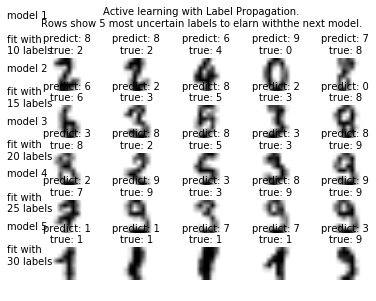

In [4]:
f = plt.figure()

for i in range(5):
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1
    
    lp_model = label_propagation.LabelPropagation(gamma=0.25, max_iter=5)
    lp_model.fit(X, y_train)
    
    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]
    
    cm =  confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)
    
    print('Iteration %i %s' %(i, 70*'_'))
    print('Label Spreading model: %d labeled & %d unlabeled (%d total)' 
         % (n_labeled_points, n_total_samples-n_labeled_points, n_total_samples))
    
    print(classification_report(true_labels, predicted_labels))
    print('Confusion matrix')
    print(cm)
    
    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)
    
    # select five digit exampels that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[-5:]
    
    # keep track of indices that we get labels for 
    delete_indices = np.array([])
    
    f.text(.05, (1-(i+1)*.183), "model %d\n\nfit with\n%d labels" 
           % ((i+1), i*5+10), size=10)
    
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]
        
        sub = f.add_subplot(5, 5, index+1+(5*i))
        sub.imshow(image, cmap=plt.cm.gray_r)
        sub.set_title('predict: %i\ntrue: %i' 
                      % (lp_model.transduction_[image_index], y[image_index]), size=10)
        sub.axis('off')
        
        # labeling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))
        
    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += 5
    
f.suptitle("Active learning with Label Propagation.\nRows show 5 most uncertain labels to elarn withthe next model.")
plt.subplots_adjust(0.12, 0.03, 0.9, 0.8, 0.2, 0.45)
plt.show()